# 2D surface trap solver

In [1]:
# %load_ext autoreload
# %autoreload 2
import sys
import logging, os
from time import time
import numpy as np
   
import matplotlib.pyplot as plt
from multiprocess import Pool # rather than import multiprocessing to work with jupyter

sys.path.append('../../')   # add path of package "bem" to search list.
sys.path.append('../../../electrode/')   # add path of package "electrode" to search list.

from bem import Electrodes, Sphere, Mesh, Grid, Configuration, Result, Box
from bem.formats import stl

import numpy as np

## Generating STL

1. In fusion 360: color electrode components with the appearance option

2. In fusion 360: export body as ``.obj`` file

3. Open ``.obj`` file in Inventor.

4. In Inventor: export/as CAD object/stl
    - Check the box for color
    - Select units: micron
    - Encoding: binary
    - Export as ``.stl``
    
5. Open ``.stl`` in MeshLab. 
6. In MeshLab, use the select faces tool to select remesh region. Remesh using the filters tab.

7. In MeshLab export to ``.ply`` with options:
    - Uncheck the box for binary
    - Check the box for color
    
8. Using ``plt_to_stl.ipynb``, convert to binary ``.stl`` with color.

## Count number of colors

In [2]:
# prefix = 'htrapv1_remesh'
prefix = 'htrapv2'

s = stl.read_stl(open(f'{prefix}.stl', "rb"))
# generates a {name: [(points, triangles)]} mesh from the stl arrays
r = stl.stl_to_mesh(*s) 

print('Electrode colors:')
print(f'Total = {len(r.keys())}\n')
for c in r.keys():
    print(c[4:])

Electrode colors:
Total = 25

2
23
1
24
11
6
22
21
20
19
18
17
16
15
14
13
25
12
10
9
8
7
5
4
3


## Color to electrode map

Colors that are not reassigned electrode names in ``stl.stl_to_mesh`` are dropped (i.e. mesh is dropped)

In [3]:
cmap = {
    1   : 'RF', 
#     2   : 'trench',
    3   : 'DC10',
    4   : 'DC9',
    5   : 'DC8',
    6   : 'DC7',
    7   : 'DC6',
    8   : 'DC5',
    9   : 'DC4',
    10  : 'DC3',
    11  : 'DC2',
    12  : 'DC1',
    13  : 'DC20',
    14  : 'DC19',
    15  : 'DC18',
    16  : 'DC17',
    17  : 'DC16',
    18  : 'DC15',
    19  : 'DC14',
    20  : 'DC13',
    21  : 'DC12',
    22  : 'DC11',
#     23  : '?',
    24  : 'DC21',
    25  : 'GND',
}

# cmap = {9495: "DC1", 17962: "DC3", 18994: "DC5",18869: "DC2", 20943: "RF", 18129: "DC4"}

dropping 2
dropping 23


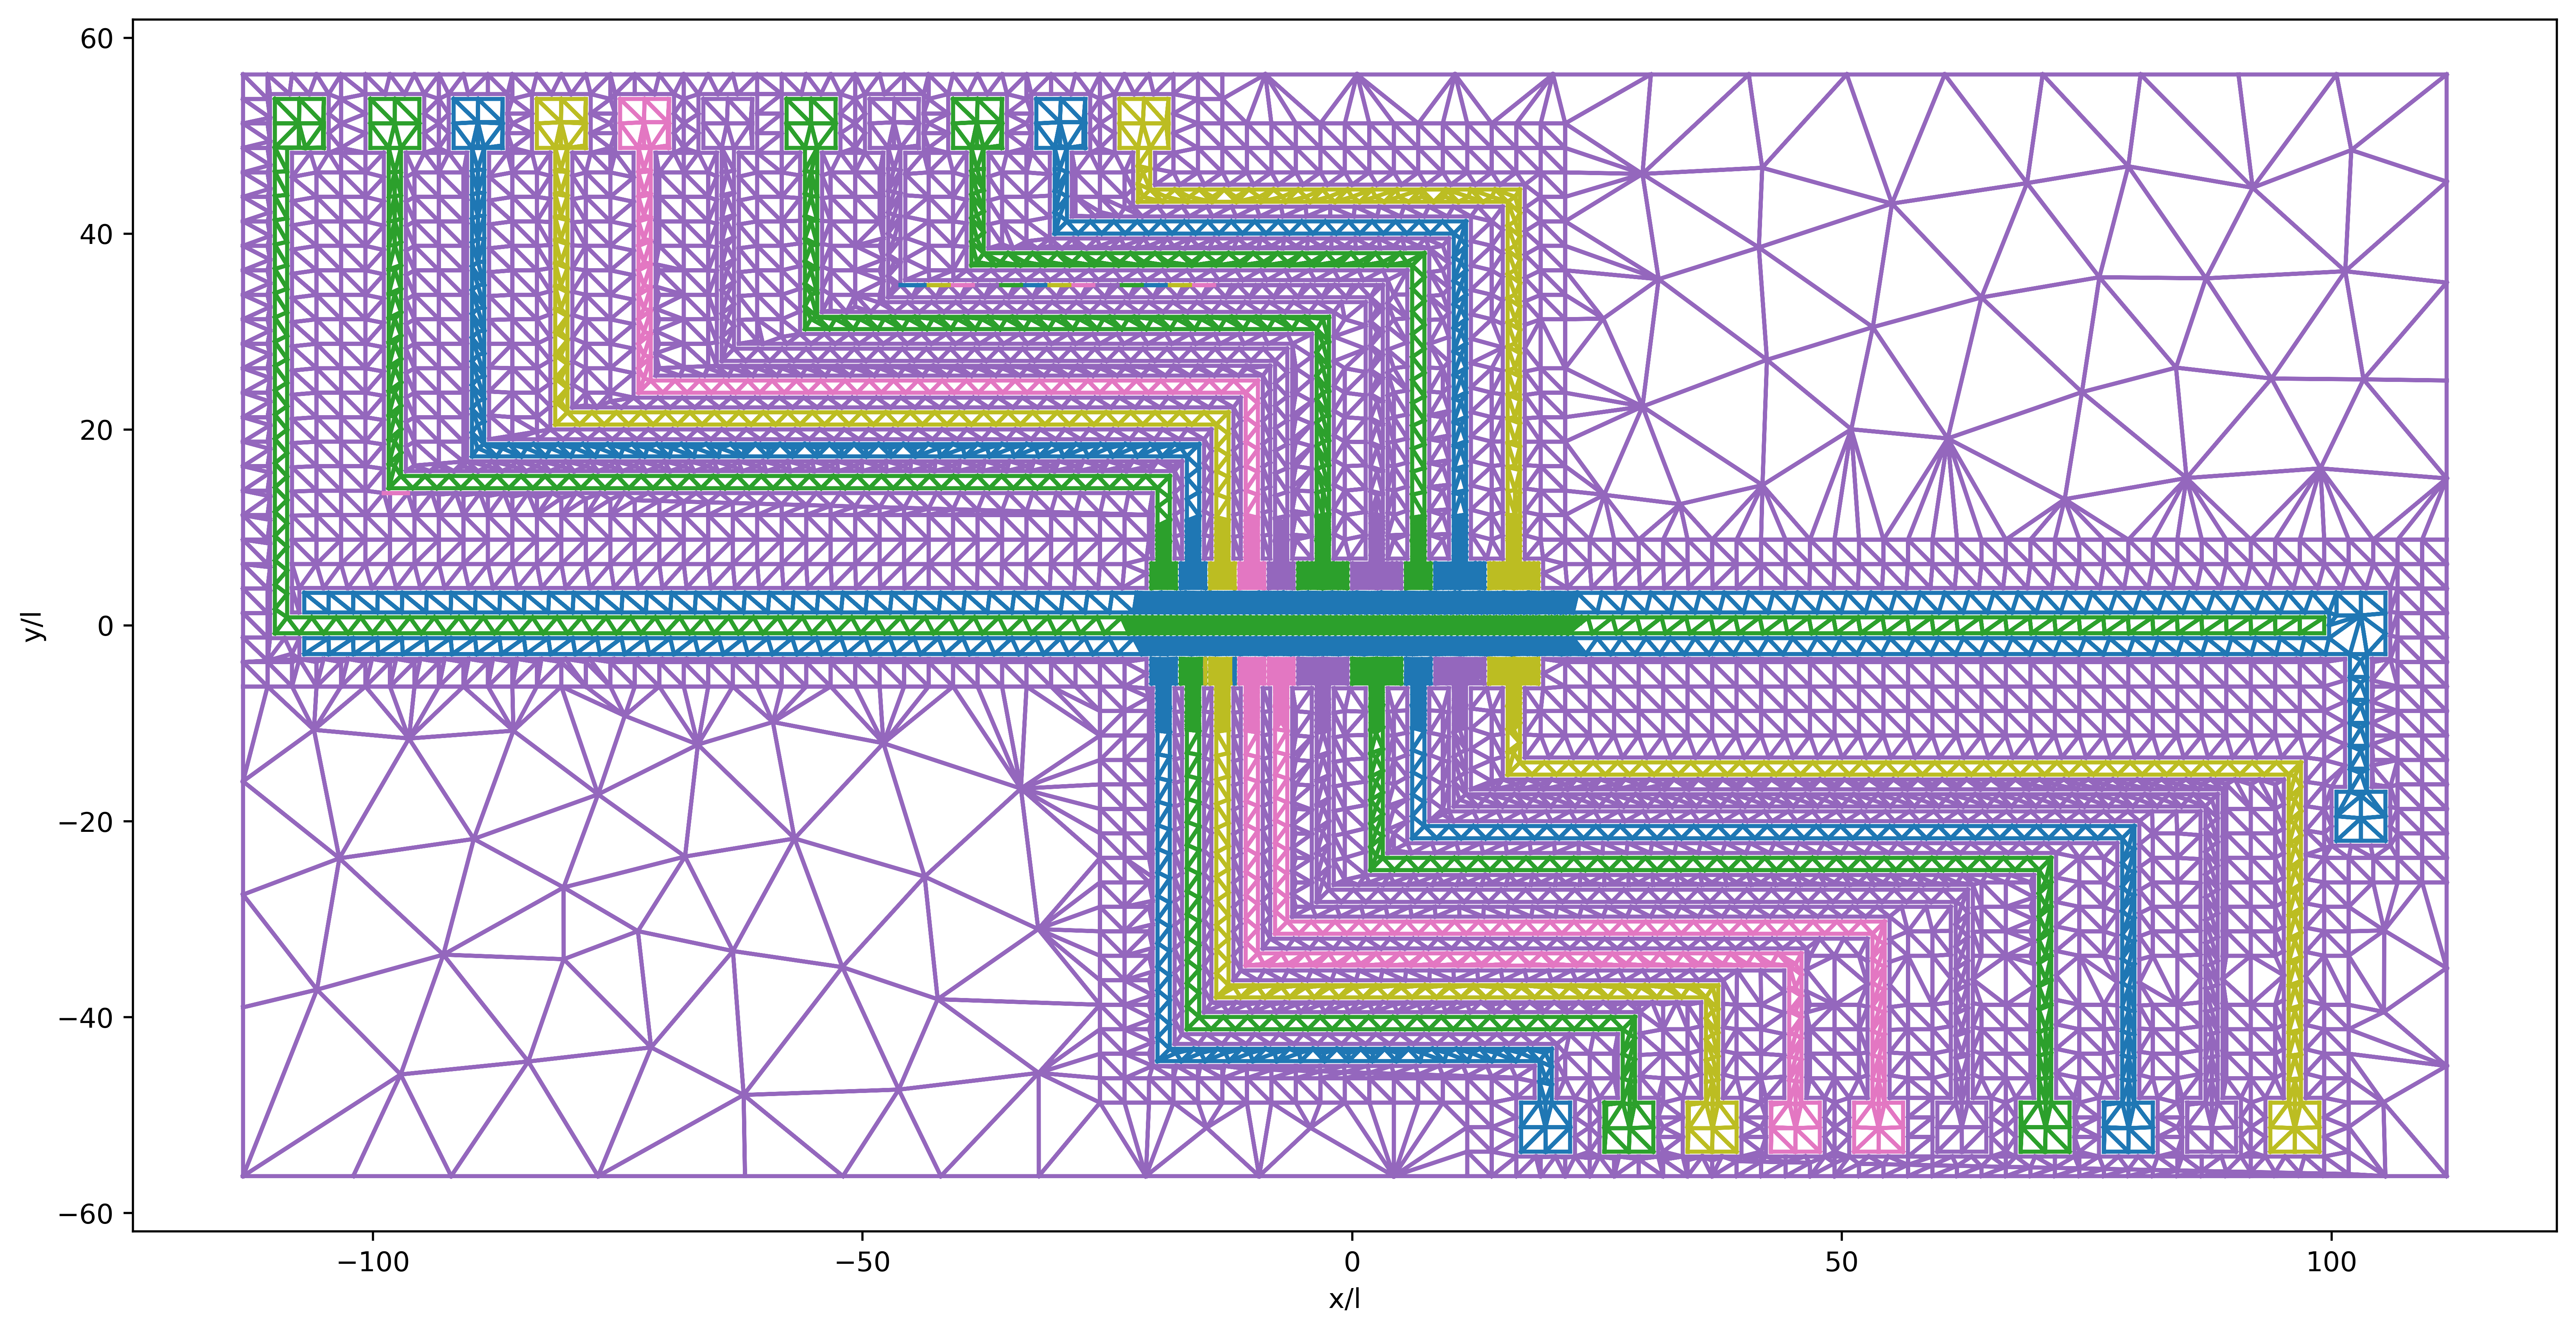

In [5]:
scale = 40

s = stl.read_stl(open(f'{prefix}.stl', "rb"))
# stl.check_normals(*s[:2])
r = stl.stl_to_mesh(*s, scale=scale, rename=cmap) 
# r = stl.split_by_normal(r)
mesh = Mesh.from_mesh(r)

# mesh.triangulate(opts='', new=False)

# Plot mesh
fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"), figsize=(16,10), dpi=500)
ax.set_xlabel("x/l",fontsize=10)
ax.set_ylabel("y/l",fontsize=10)
# ax.text(-1.5,7,"l = %d um"%(scale/1e-6),fontsize=12)
mesh.plot(ax)
# plt.savefig('fig.png', bbox_inches='tight')

### Boundary element calculations

In [5]:
# Define calculation function.
def run_job(args):
    # job is Configuration instance.
    job, grid, prefix = args
    
    # refine twice adaptively with increasing number of triangles, min angle 25 deg.
#     job.adapt_mesh(triangles=4e2, opts="q25Q")
#     job.adapt_mesh(triangles=1e3, opts="q25Q")
    
    # solve for surface charges
    job.solve_singularities(num_mom=4, num_lev=3)
    
    # get potentials and fields
    result = job.simulate(grid, field=job.name=="RF", num_lev=2)    # For "RF", field=True computes the field.
    result.to_vtk(prefix)
    print("finished job %s" % job.name)
    return job.collect_charges()

In [6]:
# grid to evalute potential and fields at. Create a grid in unit of scaled length l. Only choose the interested region (trap center) to save time.
n, s = 2*10, 0.08
Lx, Ly, Lz = 2, 2, 2    # in the unit of scaled length l
sx, sy, sz = s, s, s
# ni is grid point number, si is step size. Thus to fix size on i direction you need to fix ni*si.
nx, ny, nz = [2*np.ceil(L/2.0/s).astype('int') for L in (Lx, Ly, Lz)]
print("Size/l:", Lx, Ly, Lz)
print("Step/l:", sx, sy, sz)
print("Shape (grid point numbers):", nx, ny, nz)
grid = Grid(center=(0, 0, 1.5), step=(sx, sy, sz), shape=(nx, ny, nz))
# Grid center (nx, ny ,nz)/2 is shifted to origin
print("Grid origin/l:", grid.get_origin()[0])


Size/l: 2 2 2
Step/l: 0.08 0.08 0.08
Shape (grid point numbers): 26 26 26
Grid origin/l: -1.0


In [86]:
suffix = ''

# generate electrode potential configurations to simulate
# use regexps to match electrode names
jobs = list(Configuration.select(mesh, "DC.*","RF"))    # select() picks one electrode each time.
# run the different electrodes on the parallel pool
pmap = Pool().map # parallel map
# pmap = map # serial map
t0 = time()

list(pmap(run_job, ((job, grid, prefix+suffix) for job in jobs)))
print("Computing time: %f s"%(time()-t0))
# run_job casts a word after finishing each electrode.

d edges): 3

Reconstructing mesh.

Writing vertices.
Writing triangles.

Statistics:

  Input vertices: 3
  Input triangles: 1

  Mesh vertices: 3
  Mesh triangles: 1
  Mesh edges: 3
  Mesh exterior boundary edges: 3
  Mesh interior boundary edges: 0
  Mesh subsegments (constrained edges): 3

Reconstructing mesh.

Writing vertices.
Writing triangles.

Statistics:

  Input vertices: 3
  Input triangles: 1

  Mesh vertices: 3
  Mesh triangles: 1
  Mesh edges: 3
  Mesh exterior boundary edges: 3
  Mesh interior boundary edges: 0
  Mesh subsegments (constrained edges): 3

Reconstructing mesh.

Writing vertices.
Writing triangles.

Statistics:

  Input vertices: 3
  Input triangles: 1

  Mesh vertices: 3
  Mesh triangles: 1
  Mesh edges: 3
  Mesh exterior boundary edges: 3
  Mesh interior boundary edges: 0
  Mesh subsegments (constrained edges): 3

Reconstructing mesh.

Writing vertices.
Writing triangles.

Statistics:

  Input vertices: 3
  Input triangles: 1

  Mesh vertices: 3
  Mesh tri

finished job DC11
finished job DC2
finished job DC13
finished job RF
finished job DC12
finished job DC7
finished job DC14
finished job DC21
finished job DC15
finished job DC1
finished job DC17
finished job DC19
finished job DC16
finished job DC4
finished job DC18
finished job DC20
finished job DC3
finished job DC5
finished job DC6
finished job DC9
finished job DC8
finished job DC10
Computing time: 5814.822637 s


p max 0.23253019209
yz plane, RF pseudo


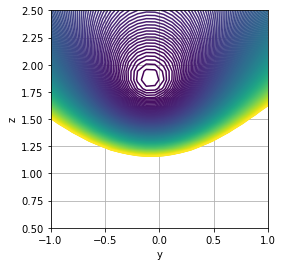

In [7]:
suffix = ''
# isocontour plot of RF pseudopotential radially from x (axial) direction
result = Result.from_vtk(prefix+suffix, "RF")
p = result.pseudo_potential
maxp = np.amax(p)
print("p max", maxp)
p = p[p.shape[0]//2]    # get a slice of yz plane at x = p.shape[0]/2.

x = grid.to_mgrid()[:, p.shape[0]//2]    # p.shape[0]/2 is in the middle of x.
print("yz plane, RF pseudo")
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(x[1], x[2], p, levels=np.linspace(0, 1e-2, 200)) 
ax.set_xlabel('y')
ax.set_ylabel('z')
ax.grid()

# plt.savefig('rfpot.png', bbox_inches='tight')

In [9]:
# explore it in fancy 3D
# fire up a mayavi2 window showing base mesh, charges on final mesh
# and isosurfaces of the pseudopotential



Result.view(prefix+suffix, "RF")
# need to start the full eventloop for the window.
# close it to return control to the notebook

from pyface.api import GUI
GUI().start_event_loop()

# Can't lauch GUI through X11 remote and caused dead kernel.